In [1]:
## inaguaral pybaseball notebook !! 
#imports
from pybaseball import statcast
from pybaseball import statcast_pitcher
from pybaseball import statcast_batter
from pybaseball import playerid_lookup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import logging
import polars as pl
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
%matplotlib inline

In [2]:
logging.basicConfig(
        filename='zachwheeler.log',
        level=logging.DEBUG, 
        format='%(asctime)s - %(levelname)s - %(message)s',
        filemode='a' # Use 'a' for append (default), or 'w' for overwrite
    )
logger= logging.getLogger(__name__)

In [3]:
#find playerid lookup of zack wheeler
pitcher= playerid_lookup("wheeler","zack")
pitcherid = pitcher.loc[0,"key_mlbam"]
pitcherid = float(pitcherid)
#pull zack wheeler's pitch data from the 2020 to 2025 seasons
wheeler_pitches = statcast_pitcher('2020-04-02', '2025-10-09', pitcherid)
wheeler_pitches.shape

Gathering player lookup table. This may take a moment.
Gathering Player Data


(17340, 118)

In [4]:
#convert wheeler_pitches from pandas dataframe to polars dataframe
wheeler_pitches = pl.from_pandas(wheeler_pitches)
#create new column which is the unique ID of the at bat
wheeler_pitches = wheeler_pitches.with_columns(
    pl.concat_str([pl.col("game_pk").cast(pl.Utf8), pl.lit("_"), pl.col("at_bat_number").cast(pl.Utf8)]).alias("ab_id")
)


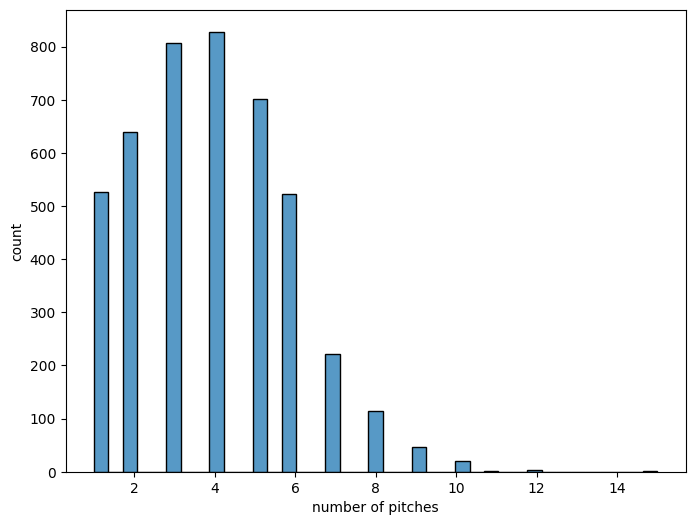

In [5]:
#count unique number of ab_ids so that we can have an idea of how much data we should have
abs = wheeler_pitches["ab_id"].n_unique()
logger.info(f"there are {abs} at-bats in these data")

#plot the distribution of pitches per at bat id
grouped_counts = wheeler_pitches.group_by("ab_id").agg(
    pl.count("ab_id").alias("pitch_count")
)
# print a histogram of the pitch_count column of grouped_counts
plt.figure(figsize=(8,6))
sns.histplot(data=grouped_counts, x="pitch_count")
plt.xlabel("number of pitches")
plt.ylabel("count")
plt.show()

In [6]:
# pitch tunneling, for Zack's most common pitch combinations, what is the most location differential to maximize deception?
#identify two pitch sequences that he uses within at-bats, might want to use the one that gives you a whiff or contact on
#the last pitch of the at bat
# Create a column with the next pitch type in the at-bat
pitch_sequences = wheeler_pitches.with_columns(
    next_pitch_type=pl.col("pitch_type").shift(-1).over("ab_id", order_by="pitch_number")
)


# Filter out the last pitch of each at-bat (where next_pitch_type is null)
pitch_sequences = pitch_sequences.filter(pl.col('next_pitch_type').is_not_null())

# Create a sequence label
pitch_sequences = pitch_sequences.with_columns(
    sequence = pl.concat_str([
        pl.col('pitch_type'),
        pl.lit('-'),
        pl.col('next_pitch_type')
    ])
)

# Count each two-pitch sequence
sequence_counts = pitch_sequences.group_by('sequence').agg(
    pl.count().alias('count')
).sort('count', descending=True)
print(sequence_counts)

shape: (49, 2)
┌──────────┬───────┐
│ sequence ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ FF-FF    ┆ 2346  │
│ FF-FC    ┆ 1098  │
│ FC-FF    ┆ 1031  │
│ SI-SI    ┆ 749   │
│ FF-SI    ┆ 739   │
│ …        ┆ …     │
│ CH-CU    ┆ 16    │
│ null     ┆ 5     │
│ FS-CH    ┆ 2     │
│ SL-FF    ┆ 1     │
│ FF-SL    ┆ 1     │
└──────────┴───────┘


In [7]:
#filter by the last or second to last pitches in a given at bat
lastpitches = wheeler_pitches.with_columns(
    max_pitch = pl.col("pitch_number").max().over("ab_id")
).filter(
    (pl.col("pitch_number") == pl.col("max_pitch")) |
    (pl.col("pitch_number") == (pl.col("max_pitch") - 1))
).drop("max_pitch").sort(["ab_id", "pitch_number"])

logger.info(f"there are {lastpitches.shape[0]} last pitches in these data")

In [8]:
#calculate the percent of the total that is each of these rows
sequence_counts = sequence_counts.with_columns(
    (pl.col("count") / pl.col("count").sum()).alias("pc_oftotal")
)

# keep only top 5 most frequent two-pitch sequences
top5_sequences = sequence_counts.sort('count', descending=True).head(5)
top5_sequences
#remember these sequences later for the optimizer
unique_sequences = top5_sequences["sequence"].to_list()

statcast pitch type documentation is listed here https://baseballsavant.mlb.com/csv-docs#:~:text=The%20documentation%20for%20Statcast%20Search%20CSV%20data,measured%20in%20feet%20from%20the%20catcher's%20perspective

ok, so let's think about what we want to optimize on
we want to maximize strikeouts obviously, minimize hits, and minimize walks

In [9]:
#count the number of each unique events column entry in lastpitches
event_counts = lastpitches.group_by("events").agg(
    pl.count().alias("count")
).sort("count", descending=True)
event_counts.tail(10)

events,count
str,u32
"""field_error""",25
"""triple""",18
"""sac_fly""",15
"""double_play""",13
"""sac_bunt""",9
"""truncated_pa""",8
"""strikeout_double_play""",7
"""fielders_choice""",6
"""intent_walk""",4


In [10]:
# Lazy version
sequences = wheeler_pitches.lazy().sort(['ab_id', 'pitch_number']).with_columns([
    # Get next pitch info
    pl.col('pitch_type').shift(1).over('ab_id').alias('first_pitch_type'),
    pl.col('plate_x').shift(1).over('ab_id').alias('first_plate_x'),
    pl.col('plate_z').shift(1).over('ab_id').alias('first_plate_z'),
    pl.col('release_speed').shift(1).over('ab_id').alias('first_release_speed'),
    pl.col('description').shift(1).over('ab_id').alias('first_description'),
    pl.col('events').shift(1).over('ab_id').alias('first_events'),
    pl.col('woba_value').shift(1).over('ab_id').alias('first_woba_value'),
]).filter(
    pl.col('events').is_not_null()
).with_columns([
    (pl.col('plate_x') - pl.col('first_plate_x')).alias('delta_plate_x'),
    (pl.col('plate_z') - pl.col('first_plate_z')).alias('delta_plate_z'),
    (pl.col('release_speed') - pl.col('first_release_speed')).alias('delta_velocity'),
])

# Collect to see results
sequences_df = sequences.collect()

logger.info(f"Total pitch sequences: {len(sequences_df)}")

In [11]:
# do the same as above and create a pitch sequence label
sequences_df = sequences.collect()

# Create a pitch sequence label
sequences_df = sequences_df.with_columns(
    pitch_sequence = pl.concat_str([
        pl.col('first_pitch_type'),
        pl.lit('-'),
        pl.col('pitch_type')
    ])
)

In [12]:
def get_matching_sequences(params, sequences_df, tolerances):
    """
    Find matching sequences in your data for search.
    
    Parameters:
    ----------
    params : list/tuple
        params = [delta_plate_x, delta_plate_z, delta_velocity, pitch_sequence]
    sequences_df : polars DataFrame
        DataFrame containing pitch sequences with delta columns.
    tolerances : list/tuple
        Tolerances for each delta parameter.
        tolerances = [tol_x, tol_z, tol_velocity]
    
    Returns:
    -------
    polars DataFrame
        Filtered DataFrame with matching sequences.
    """
    logging.info("Searching for matching sequences...")

    delta_x, delta_z, delta_velocity = params
    tol_x, tol_z, tol_velocity = tolerances
    logging.info(f"Parameters: delta_x={delta_x}, delta_z={delta_z}, delta_velocity={delta_velocity}")
    logging.info(f"Tolerances: tol_x={tol_x}, tol_z={tol_z}, tol_velocity={tol_velocity}")
    # Filter to sequences that are close enough to the parameters
    # KEY FIX: Add parentheses around EACH comparison
    matching = sequences_df.filter(
        ((pl.col('delta_plate_x') - delta_x).abs() < tol_x) &
        ((pl.col('delta_plate_z') - delta_z).abs() < tol_z) &
        ((pl.col('delta_velocity') - delta_velocity).abs() < tol_velocity)
    )
    logger.info(f"Found {matching.shape[0]} matching sequences for params: {params}")
    return matching

In [13]:
def cost_function_contact_quality(params, sequences_df, tolerances):
    """
    Two-part cost function:
    combining swing and miss rate with contact quality (xwOBA on contact)
    
    Parameters:
    ----------
    params : list/tuple
        [delta_plate_x, delta_plate_z, delta_velocity, pitch_sequence]
    sequences_df : polars DataFrame
        Your pitch sequences data
    tolerances : list/tuple
        [tol_x, tol_z, tol_velocity]
    
    Returns:
    -------
    float
        Cost value (lower is better)
    """
    # Get matching sequences
    matching = get_matching_sequences(params, sequences_df, tolerances)
    logging.info(f"Number of matching sequences used: {len(matching)}")
    if len(matching) < 5:
        return 0.5  # Penalty for sparse regions
    
    # PART 1: Whiff rate (no contact at all)
    # Look at all swings (including fouls and contact)
    # Note: Using 'description' (not 'next_description') since you're looking at current pitch
    swings = matching.filter(pl.col('description').is_in([
        'swinging_strike',           # Miss
        'swinging_strike_blocked',   # Miss in dirt
        'foul',                      # Contact but foul
        'foul_tip',                  # Contact but foul
        'hit_into_play'              # Contact in play
    ]))
    #log number of swings found
    logger.info(f"Number of swings found: {len(swings)}")
    
    if len(swings) > 0:
        # What % of swings resulted in complete miss? (include the blocked swing because that is still a whiff)
        whiff_rate = (
            swings['description'].str.contains('swinging_strike') |
            swings['description'].str.contains('swinging_strike_blocked')
        ).sum() / len(swings)
    else:
        whiff_rate = 0
    
    # PART 2: Contact quality (ONLY when ball is put in play)
    contact = matching.filter(
        pl.col('description') == 'hit_into_play'
    )
    #log number of times it was put into play
    logger.info(f"Number of contact events found: {len(contact)}")
    if len(contact) > 5:
        # Average xwOBA on contact
        # High xwOBA = hard contact (bad for pitcher)
        # Low xwOBA = weak contact (good for pitcher)
        avg_xwoba = contact['estimated_woba_using_speedangle'].mean()
    else:
        avg_xwoba = 0.320  # Assume league average if not enough data
    
    # COMBINE: 
    # - Lower whiff_rate is bad (they're making contact)
    # - Higher xwOBA is bad (hard contact)
    cost = (0.6 * avg_xwoba) - (0.4 * whiff_rate)
    
    return cost

In [14]:
# get some information that we can use for the tolerances 
tolerances_summary = sequences_df.select([ 'pitch_sequence', 'delta_plate_x', 'delta_plate_z', 'delta_velocity']).group_by(['pitch_sequence']).agg([
    pl.col('delta_plate_x').std().alias('std_delta_x'),
    pl.col('delta_plate_z').std().alias('std_delta_z'),
    pl.col('delta_velocity').std().alias('std_delta_velocity'),
    pl.col('delta_plate_x').mean().alias('mean_delta_x'),
    pl.col('delta_plate_z').mean().alias('mean_delta_z'),
    pl.col('delta_velocity').mean().alias('mean_delta_velocity'),
    pl.col('delta_plate_x').min().alias('min_delta_x'),
    pl.col('delta_plate_z').min().alias('min_delta_z'),
    pl.col('delta_velocity').min().alias('min_delta_velocity'),
    pl.col('delta_plate_x').max().alias('max_delta_x'),
    pl.col('delta_plate_z').max().alias('max_delta_z'),
    pl.col('delta_velocity').max().alias('max_delta_velocity'),
    pl.count().alias('count_sequence')])
tolerances_summary = tolerances_summary.filter(pl.col('pitch_sequence').is_in(unique_sequences))
tolerances_summary

pitch_sequence,std_delta_x,std_delta_z,std_delta_velocity,mean_delta_x,mean_delta_z,mean_delta_velocity,min_delta_x,min_delta_z,min_delta_velocity,max_delta_x,max_delta_z,max_delta_velocity,count_sequence
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32
"""FF-FF""",0.880682,0.886115,0.706938,-0.013207,-0.011565,0.14848,-2.69,-2.72,-3.2,2.82,2.55,3.7,658
"""FF-FC""",0.931738,1.012235,1.485026,0.364413,-0.624857,-5.147302,-2.38,-3.51,-9.6,3.03,2.26,-2.3,315
"""FF-SI""",0.944677,0.832044,0.69149,-0.755318,-0.378352,-0.500375,-2.75,-2.61,-2.5,2.22,2.02,1.0,267
"""SI-SI""",0.879058,0.89712,0.690546,0.115263,0.096429,0.125564,-2.69,-2.1,-2.3,2.64,2.49,1.9,266
"""FC-FF""",0.89841,1.104508,1.545641,-0.420987,0.626752,5.370064,-2.51,-2.71,0.9,2.28,3.74,10.1,314


let's try to use the ProcessOptimizer to find the changes in velo and location with each unique pitch combination in the top5
starting with just two pitch fastball combinations

In [15]:
#define the space for optimization (we will just use the two four-seam fastballs to start)
space = [
    Real(-2.34, 2.82, name='delta_plate_x'),
    Real(-2.56, 2.12, name='delta_plate_z'),
    Real(-2.2, 2.4, name='delta_velocity'),
]
#tolerances are hard-coded for now 
tolerances = [0.8, 0.8, 3.0]

In [16]:
# just demo this with FF-FF sequence only 
space_fastballs = sequences_df.filter(pl.col('pitch_sequence') == 'FF-FF')

In [17]:
#write wrapper function for the cost function
def costfn_wrapper(params):
    """Wrapper function for the cost function that the optimizer calls
    It only requires paramas, so we add sequences_df and tolerances here"""
    return cost_function_contact_quality(params, space_fastballs, tolerances)


In [18]:
result = gp_minimize(costfn_wrapper, space, n_calls=100, random_state=42, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0065
Function value obtained: 0.1043
Current minimum: 0.1043
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0021
Function value obtained: 0.1440
Current minimum: 0.1043
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0021
Function value obtained: 0.1508
Current minimum: 0.1043
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0018
Function value obtained: 0.0538
Current minimum: 0.0538
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0006
Function value obtained: 0.5000
Current minimum: 0.0538
Iteration No: 6 started. Evaluating

In [19]:
logger.info('Finished')